# Notebook for running characterizing spots on BOT data.

Initially written 16 Dec 2019 by Craig Lage.\
Looking at spot profiles.\
Re-running this on 08Jan20 with the latest daily.\
Running on ITL 11 Mar 2020.


In [1]:
! eups list -s | grep lsst_distrib
! eups list -s obs_lsst # tickets/DM-22605
! eups list -s cp_pipe # tickets/DM-18683

lsst_distrib          19.0.0+65  	current w_2020_10 setup
   LOCAL:/home/cslage/alternate_branches/obs_lsst 	setup
   LOCAL:/home/cslage/alternate_branches/cp_pipe 	setup


In [2]:
import sys, os, glob, time
import pickle as pkl
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import astropy.io.fits as pf

import eups
from lsst.daf.persistence import Butler
import lsst.afw.image as afwImage
import lsst.geom as geom
from lsst.daf.persistence import Butler
from lsst.ip.isr.isrTask import IsrTask, IsrTaskConfig
from lsst.ip.isr.isrFunctions import brighterFatterCorrection
from lsst.meas.algorithms import SourceDetectionTask
from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask, CharacterizeImageConfig
from lsst.geom import Point2I, Box2I

In [6]:
raftName = 'R02'
detectorName = 'S02'
DATA_DIR = '/project/shared/BOT/'
REPO_DIR = '/project/cslage/BOT/ITL_11Mar20/'
OUTPUT_DIR = '/project/cslage/BOT/ITL_11Mar20/'
DETECTOR = 11

In [4]:
# This sets up the visits.  
starting_visit = 3019103102226
ending_visit = 3019103102366

visits = []
visit_1 = starting_visit
while visit_1 < ending_visit+1:
    visits.append(visit_1)
    visit_1 += 20 # Skipping the bias frames in between
visits.append(3019110100001)
starting_visit = 3019110100013
ending_visit = 3019110100093
visit_1 = starting_visit
while visit_1 < ending_visit+1:
    visits.append(visit_1)
    visit_1 += 20 # Skipping the bias frames in between
print(visits)
print(len(visits))

[3019103102226, 3019103102246, 3019103102266, 3019103102286, 3019103102306, 3019103102326, 3019103102346, 3019103102366, 3019110100001, 3019110100013, 3019110100033, 3019110100053, 3019110100073, 3019110100093]
14


In [7]:
# Now set up the isrConfig and charConfig 
# The master bias, flat, and dark images have already been created and ingested.
butler = Butler(OUTPUT_DIR)

isrConfig = IsrTaskConfig()
isrConfig.doLinearize = False
isrConfig.doBias = True
isrConfig.doFlat = False
isrConfig.doDark = True
isrConfig.doFringe = False
isrConfig.doDefect = False
isrConfig.doAddDistortionModel = False
isrConfig.doWrite = False
isrConfig.doBrighterFatter = False
isrConfig.doApplyGains = False
isrTask = IsrTask(config=isrConfig)

charConfig = CharacterizeImageConfig()
charConfig.installSimplePsf.fwhm = 1.0
charConfig.doMeasurePsf = False
charConfig.doApCorr = False
charConfig.doDeblend = False
charConfig.repair.doCosmicRay = True
charConfig.repair.doInterpolate = False   
charConfig.detection.background.binSize = 32
charConfig.detection.minPixels = 10
charTask = CharacterizeImageTask(config=charConfig)

/opt/lsst/software/stack/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/python3.7/site-packages/ipykernel/__main__.py:12: FutureWarning: Config field doAddDistortionModel is deprecated: Camera geometry is incorporated when reading the raw files. This option no longer is used, and will be removed after v19.


In [8]:
# Now get the gain and kernels
bf_butler = Butler(OUTPUT_DIR)
bf_kernel = bf_butler.get('brighterFatterKernel', dataId={'detector': DETECTOR})
gains = bf_kernel.gain
kernels = bf_kernel.ampwiseKernels
print(gains['C10'])
print(kernels['C10'])

1.51920469365095
[[-9.19004666e-10 -1.95722360e-09 -3.07869344e-09 -4.25232135e-09
  -5.43179726e-09 -6.54360221e-09 -7.48292287e-09 -8.12404659e-09
  -8.35374018e-09 -8.12404659e-09 -7.48292287e-09 -6.54360221e-09
  -5.43179726e-09 -4.25232135e-09 -3.07869344e-09 -1.95722360e-09
  -9.19004666e-10]
 [-1.95900225e-09 -4.11542211e-09 -6.44044071e-09 -8.89111695e-09
  -1.13843174e-08 -1.37723536e-08 -1.58282418e-08 -1.72591575e-08
  -1.77791847e-08 -1.72591575e-08 -1.58282418e-08 -1.37723536e-08
  -1.13843174e-08 -8.89111695e-09 -6.44044071e-09 -4.11542211e-09
  -1.95900225e-09]
 [-3.08580805e-09 -6.44950206e-09 -1.00939798e-08 -1.39907228e-08
  -1.80416360e-08 -2.20325983e-08 -2.55883875e-08 -2.81596529e-08
  -2.91228054e-08 -2.81596529e-08 -2.55883875e-08 -2.20325983e-08
  -1.80416360e-08 -1.39907228e-08 -1.00939798e-08 -6.44950206e-09
  -3.08580805e-09]
 [-4.26993979e-09 -8.92024775e-09 -1.40175542e-08 -1.95894757e-08
  -2.55693344e-08 -3.17131212e-08 -3.74879413e-08 -4.19513214e-08
  

In [9]:
# Now we try running on all of the spot images

minSizeX = 4.0
maxSizeX = 7.0
minSizeY = 4.0
maxSizeY = 7.0
minX = minY = 1000
maxX = maxY = 3500
minFluxRatio = 0.80

byamp_results = []
byamp_corrected_results = []
for i, spot_visit in enumerate(visits):
    if i == 7:
        numVisits = 8
    elif i == 8:
        numVisits = 12
    else:
        numVisits = 20
    numVisits = 2
    for do_bf_corr in [False, True]:
        isrConfig.doBrighterFatter = do_bf_corr
        isrTask = IsrTask(config=isrConfig)
        for j in range(numVisits):
            sub_visit = spot_visit + j
            #print("Getting exposure # %d"%sub_visit)
            rawSpotDataRef = butler.dataRef('raw', detector=DETECTOR, visit=sub_visit)
            postIsrSpot = isrTask.runDataRef(rawSpotDataRef).exposure
            ccd = postIsrSpot.getDetector()
            #for amp in ccd:
            #    gain = gains[amp.getName()]
            #    img = postIsrSpot.image
            #    sim = img.Factory(img, amp.getBBox())
            #    sim *= gain
            #    if do_bf_corr:
            #        brighterFatterCorrection(postIsrSpot[amp.getBBox()],kernels[amp.getName()],20,10,False)
            charResult = charTask.run(postIsrSpot)
            spotCatalog = charResult.sourceCat
            maxFlux = np.nanmax(spotCatalog['base_SdssShape_instFlux'])
            select = spotCatalog['base_SdssShape_instFlux'] > maxFlux * minFluxRatio
            spotCatalog  = spotCatalog.subset(select)
            select = ((spotCatalog['base_SdssShape_xx'] >= minSizeX) & (spotCatalog['base_SdssShape_xx'] <= maxSizeX) & 
                    (spotCatalog['base_SdssShape_yy'] >= minSizeY) & (spotCatalog['base_SdssShape_yy'] <= maxSizeY) &
                    (spotCatalog['base_SdssCentroid_x'] >= minX) & (spotCatalog['base_SdssCentroid_x'] <= maxX) &
                    (spotCatalog['base_SdssCentroid_y'] >= minY) & (spotCatalog['base_SdssCentroid_y'] <= maxY))

            spotCatalog  = spotCatalog.subset(select)
            if j == 0:
                print("Correction = %s, Exposure # %d, %d spots"%(str(do_bf_corr),sub_visit, len(spotCatalog['base_SdssShape_instFlux'])))
                x2 = spotCatalog['base_SdssShape_xx']
                y2 = spotCatalog['base_SdssShape_yy']
                flux = spotCatalog['base_SdssShape_instFlux']
            else:
                print("Correction = %s, Exposure # %d, %d spots"%(str(do_bf_corr),sub_visit, len(spotCatalog['base_SdssShape_instFlux'])))
                x2 = np.concatenate((x2, spotCatalog['base_SdssShape_xx']))
                y2 = np.concatenate((y2, spotCatalog['base_SdssShape_yy']))
                flux = np.concatenate((flux, spotCatalog['base_SdssShape_instFlux']))

        numspots = len(flux)
        print("Correction = %s, Detected %d objects, Flux = %f, X2 = %.3f +/- %.3f, Y2 = %.3f +/- %.3f"%(str(do_bf_corr),numspots, \
                                np.nanmean(flux),np.nanmean(x2),np.nanstd(x2),np.nanmean(y2),np.nanstd(y2)))
        sys.stdout.flush()                                
        if do_bf_corr:
            byamp_corrected_results.append([numspots, np.nanmean(flux), np.nanstd(flux), np.nanmean(x2), np.nanstd(x2),
                                   np.nanmean(y2), np.nanstd(y2)])
        else:
            byamp_results.append([numspots, np.nanmean(flux), np.nanstd(flux), np.nanmean(x2), np.nanstd(x2),
                                   np.nanmean(y2), np.nanstd(y2)])
spots_pickle = {'results':byamp_results, 'corrected_results': byamp_corrected_results}
filename = OUTPUT_DIR+"/spots_results_11mar20.pkl"
with open(filename, 'wb') as f:
    pkl.dump(spots_pickle, f)



Correction = False, Exposure # 3019103102226, 796 spots
Correction = False, Exposure # 3019103102227, 796 spots
Correction = False, Detected 1592 objects, Flux = 394691.228080, X2 = 5.182 +/- 0.068, Y2 = 5.307 +/- 0.052
Correction = True, Exposure # 3019103102226, 797 spots
Correction = True, Exposure # 3019103102227, 796 spots
Correction = True, Detected 1593 objects, Flux = 394216.401294, X2 = 5.145 +/- 0.067, Y2 = 5.269 +/- 0.052
Correction = False, Exposure # 3019103102246, 796 spots
Correction = False, Exposure # 3019103102247, 794 spots
Correction = False, Detected 1590 objects, Flux = 531273.571263, X2 = 5.238 +/- 0.072, Y2 = 5.355 +/- 0.054
Correction = True, Exposure # 3019103102246, 796 spots
Correction = True, Exposure # 3019103102247, 794 spots
Correction = True, Detected 1590 objects, Flux = 530456.781811, X2 = 5.187 +/- 0.071, Y2 = 5.304 +/- 0.054
Correction = False, Exposure # 3019103102266, 798 spots
Correction = False, Exposure # 3019103102267, 794 spots
Correction = F

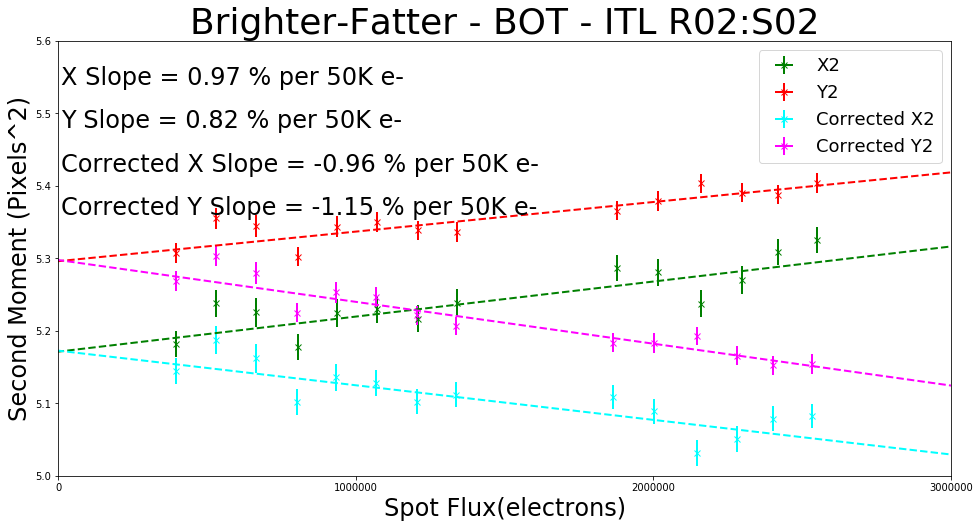

In [12]:
plotCorrection = True
filename = OUTPUT_DIR+"/spots_results_11mar20.pkl"
with open(filename, 'rb') as f:
    spots_pickle= pkl.load(f)
byamp_results = spots_pickle['results']
if plotCorrection:
    byamp_corrected_results = spots_pickle['corrected_results']

# Now plot the result
from scipy import stats
plotCorrection=True
syst_fraction = 0.25
min_slope_index = 2
max_slope_index = len(byamp_results) - 1
max_flux_index = len(byamp_results)
minSpot = 5.0
maxSpot = 5.6
textDelta = (maxSpot - minSpot) / 10
# These next are in case not all fluxes produced good results

try:
    results = np.array([byamp_results[i] for i in range(max_flux_index)])
    max_slope_ind = max_slope_index
except:
    results = np.array(byamp_results)
    max_slope_ind = min(len(results) - 4, max_slope_index)
xerror = results[:,2]/np.sqrt(results[:,0])
xyerror = results[:,4] * (syst_fraction + (1 - syst_fraction) / np.sqrt(results[:,0]))
yyerror = results[:,6] * (syst_fraction + (1 - syst_fraction) / np.sqrt(results[:,0]))

if plotCorrection:
    try:
        corrected_results = np.array([byamp_corrected_results[i] for i in range(max_flux_index)])
        max_slope_ind_corr = max_slope_index
    except:
        corrected_results = np.array(byamp_corrected_results)           
        max_slope_ind_corr = min(len(corrected_results) - 4, max_slope_index)

    corrected_xerror = corrected_results[:,2]/np.sqrt(corrected_results[:,0])
    corrected_xyerror = corrected_results[:,4] * (syst_fraction + (1 - syst_fraction) / np.sqrt(corrected_results[:,0]))
    corrected_yyerror = corrected_results[:,6] * (syst_fraction + (1 - syst_fraction) / np.sqrt(corrected_results[:,0]))

plt.figure(figsize=(16,8))
plt.title("Brighter-Fatter - BOT - ITL R02:S02", fontsize = 36)
# First plot the uncorrected data
plt.errorbar(results[:,1], results[:,3], xerr = xerror, 
             yerr = xyerror, color = 'green', lw = 2, label = 'X2', ls='', marker='x')
plt.errorbar(results[:,1], results[:,5], xerr = xerror, 
             yerr = yyerror, color = 'red', lw = 2, label = 'Y2', ls='',marker='x')
slope, intercept, r_value, p_value, std_err = stats.linregress(results[min_slope_index:max_slope_ind,1], results[min_slope_index:max_slope_ind,3])
xplot=np.linspace(-5000.0,5000000.0,100)
yplot = slope * xplot + intercept
plt.plot(xplot, yplot, color='green', lw = 2, ls = '--')
tslope = slope * 100.0 * 200000.0
plt.text(10000.0,maxSpot-textDelta,"X Slope = %.2f %% per 50K e-"%tslope, fontsize=24)

slope, intercept, r_value, p_value, std_err = stats.linregress(results[min_slope_index:max_slope_ind,1], results[min_slope_index:max_slope_ind,5])
xplot=np.linspace(-5000.0,5000000.0,100)
yplot = slope * xplot + intercept
plt.plot(xplot, yplot, color='red', lw = 2, ls = '--')
tslope = slope * 100.0 * 200000.0
plt.text(10000.0,maxSpot-2*textDelta,"Y Slope = %.2f %% per 50K e-"%tslope, fontsize=24)

if plotCorrection:
    # Now plot the corrected data
    plt.errorbar(corrected_results[:,1], corrected_results[:,3], xerr = corrected_xerror, 
                yerr = corrected_xyerror, color = 'cyan', lw = 2, ls='', marker='x', label = 'Corrected X2')
    plt.errorbar(corrected_results[:,1], corrected_results[:,5], xerr = corrected_xerror,
                yerr = corrected_yyerror, color = 'magenta', lw = 2, ls='', marker='x', label = 'Corrected Y2')
    slope, intercept, r_value, p_value, std_err = stats.linregress(corrected_results[min_slope_index:max_slope_ind_corr,1], corrected_results[min_slope_index:max_slope_ind_corr,3])
    xplot=np.linspace(-5000.0,5000000.0,100)
    yplot = slope * xplot + intercept
    plt.plot(xplot, yplot, color='cyan', lw = 2, ls = '--')
    tslope = slope * 100.0 * 200000.0
    plt.text(10000.0,maxSpot-3*textDelta,"Corrected X Slope = %.2f %% per 50K e-"%tslope, fontsize=24)

    slope, intercept, r_value, p_value, std_err = stats.linregress(corrected_results[min_slope_index:max_slope_ind_corr,1], corrected_results[min_slope_index:max_slope_ind_corr,5])
    xplot=np.linspace(-5000.0,5000000.0,100)
    yplot = slope * xplot + intercept
    plt.plot(xplot, yplot, color='magenta', lw = 2, ls = '--')
    tslope = slope * 100.0 * 200000.0
    plt.text(10000.0,maxSpot-4*textDelta,"Corrected Y Slope = %.2f %% per 50K e-"%tslope, fontsize=24)

plt.xlim(0.0,3000000.0)
plt.xticks([0,1000000,2000000, 3000000])
plt.ylim(minSpot, maxSpot)
plt.xlabel('Spot Flux(electrons)',fontsize=24)
plt.ylabel('Second Moment (Pixels^2)',fontsize=24)
plt.legend(loc= 'upper right',fontsize = 18)
plt.savefig(OUTPUT_DIR+"plots/BF_Slopes_ITL_11Mar20.pdf")
